In [1]:
import dask.dataframe as dd

#Load the dataset with Dask
data = dd.read_csv('/home/olive0927/DFCI_projects/HDAC1_analysis/Deleteome_analysis/deleteome_all_mutants_ex_wt_var_controls_111024.txt', sep='\t', dtype=str)

data = data.loc[1:].reset_index(drop=True)
data.head()

,reporterId,systematicName,geneSymbol,swd1-del-matA vs. wt-matA,swd1-del-matA vs. wt-matA.1,swd1-del-matA vs. wt-matA.2,ptc1-del vs. wt,ptc1-del vs. wt.1,ptc1-del vs. wt.2,tlc1-del vs. wt,...,uba3-del vs. wt.2,wt-matA vs wt,wt-matA vs wt.1,wt-matA vs wt.2,wt-by4743 vs. wt,wt-by4743 vs. wt.1,wt-by4743 vs. wt.2,wt-ypd vs. wt,wt-ypd vs. wt.1,wt-ypd vs. wt.2
0,SCAB000001,Q0010,Q0010,0.0076834948,5.7383149,0.958054,-0.0023376161,5.6394251,0.983617,-0.054759384,...,0.977855,5.6418191,-0.017202417,0.265474,5.7688422,0.0083864892,0.91202,5.6007679,-0.02910071,0.616744
1,SCAB000002,Q0017,Q0017,-0.093275612,5.7430479,0.432495,-0.00078359617,5.6637426,0.993043,-0.084442387,...,0.979155,5.6518733,-0.011236069,0.417339,5.845863,0.010049357,0.897931,5.6021664,-0.01279994,0.83518
2,SCAB000003,Q0032,Q0032,-0.020262902,5.8495953,0.902186,0.020754644,5.7035622,0.854116,-0.011870142,...,0.973643,5.7529281,-0.012401174,0.568422,5.8659162,0.013855263,0.905891,5.6727664,-0.007499834,0.943031
3,SCAB000004,Q0045,COX1,-0.80578684,7.3644598,2.40595e-06,-0.29111708,5.8678774,0.0181674,0.082048528,...,0.91132,6.3654176,-0.010878436,0.605649,6.6100395,-0.21042431,0.00405308,5.9680521,-0.16079984,0.019957
4,SCAB000007,Q0060,AI3,0.02238912,8.5986755,0.946646,-2.0106226,6.5326525,6.73836e-19,0.20960309,...,0.870419,7.2484737,-0.079449058,0.0686784,7.8563925,0.1831117,0.332364,6.5062512,-0.89130026,0


In [2]:
import pandas as pd
data_pd = data.compute()

In [3]:
#Initialize dictionaries for storing up and downregulated genes per condition
condition_upregulated = {}
condition_downregulated = {}

In [4]:
#Iterate over columns to find gene-del conditions (ptc1-del vs wt & similar)
for col in data_pd.columns:
    if col.endswith("wt") and "-del" in col and "mat" not in col:
        m_col = col  # M-values directly from wt
        p_col = f"{col}.2"  # p-values from wt.2

        #Verify both M-value & p-value columns exist
        if m_col in data_pd.columns and p_col in data_pd.columns:
            
            #Convert to numeric, coercing any errors
            data_pd[m_col] = pd.to_numeric(data_pd[m_col], errors='coerce')
            data_pd[p_col] = pd.to_numeric(data_pd[p_col], errors='coerce')

            #Filter significant genes with p-value < 0.05
            significant_genes = data_pd.loc[data_pd[p_col] < 0.05].copy()  # Ensure we're working with a copy

            #Calculate Fold Change (FC) from M (log2FC), where FC = 2 ^ M
            significant_genes['Fold Change'] = 2 ** significant_genes[m_col]

            #Store up & downregulated genes with correct FC cutoffs (FC > 2 for up, FC < 0.5 for down)
            up_genes = significant_genes.loc[significant_genes['Fold Change'] > 2, 'systematicName'].tolist()  #FC > 2
            down_genes = significant_genes.loc[significant_genes['Fold Change'] < 0.5, 'systematicName'].tolist()  #FC < 0.5

            #Add to dictionaries
            condition_upregulated[m_col] = up_genes
            condition_downregulated[m_col] = down_genes

            #Print summary only if we've > 100 DGEs (either up or downregulated)
            if len(up_genes) > 100 or len(down_genes) > 100:
                print(f"Condition: {m_col}")
                if len(up_genes) > 100:
                    print(f"  Upregulated Genes (FC > 2): {len(up_genes)}")
                if len(down_genes) > 100:
                    print(f"  Downregulated Genes (FC < 0.5): {len(down_genes)}\n")
        else:
            print(f"Skipping {col}: Either {m_col} or {p_col} not found.")

#Printing the results for rpd3 & sin3 conditions as you specified
print("RPD3-del Condition:")
print(f"  Upregulated Genes: {len(condition_upregulated.get('rpd3-del vs. wt', []))}")
print(f"  Downregulated Genes: {len(condition_downregulated.get('rpd3-del vs. wt', []))}")

print("\nSin3-del Condition:")
print(f"  Upregulated Genes: {len(condition_upregulated.get('sin3-del vs. wt', []))}")
print(f"  Downregulated Genes: {len(condition_downregulated.get('sin3-del vs. wt', []))}")

#Fully reproduced with /DFCI_projects/HDAC1_analysis/scRNAseq_analysis_Nature/deleteome_analysis/Deleteome_analysis_FC2_pval0.05_28012025.ipynb 

Condition: ptc1-del vs. wt
  Upregulated Genes (FC > 2): 151
Condition: tlc1-del vs. wt
  Upregulated Genes (FC > 2): 293
Condition: swa2-del vs. wt
  Upregulated Genes (FC > 2): 210
Condition: sfp1-del vs. wt
  Upregulated Genes (FC > 2): 145
  Downregulated Genes (FC < 0.5): 110

Condition: thp1-del vs. wt
  Upregulated Genes (FC > 2): 124
Condition: nam7-del vs. wt
  Upregulated Genes (FC > 2): 241
Condition: ino4-del vs. wt
  Upregulated Genes (FC > 2): 158
Condition: caf17-del vs. wt
  Upregulated Genes (FC > 2): 117
Condition: nmd2-del vs. wt
  Upregulated Genes (FC > 2): 246
Condition: kem1-del vs. wt
  Upregulated Genes (FC > 2): 436
  Downregulated Genes (FC < 0.5): 123

Condition: grr1-del vs. wt
  Upregulated Genes (FC > 2): 314
Condition: opi1-del vs. wt
  Upregulated Genes (FC > 2): 123
Condition: rtt109-del vs. wt
  Upregulated Genes (FC > 2): 121
Condition: vps15-del vs. wt
  Upregulated Genes (FC > 2): 189
Condition: not4-del vs. wt
  Upregulated Genes (FC > 2): 295
  D

In [5]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [6]:
#Latest RNA-seq results (yeast): 

#Load Excel with each sheet as a condition
excel_path = "DESeq2_DEGs_yeast_09042025.xlsx"
sheet_dict = pd.read_excel(excel_path, sheet_name=None)

#Initialize dictionaries to collect gene lists
up_dict = {}
down_dict = {}

#Iterate over each condition/sheet
for sheet_name, df in sheet_dict.items():
    condition = sheet_name.replace("_DEGs", "")
    df = df[['Systematic Name', 'log2FoldChange']].dropna()
    
    up_genes = df[df['log2FoldChange'] > 0]['Systematic Name'].tolist()
    down_genes = df[df['log2FoldChange'] < 0]['Systematic Name'].tolist()
    
    up_dict[condition] = up_genes
    down_dict[condition] = down_genes

#Convert dictionaries to DataFrames with consistent columns
bulk_rna_up = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in up_dict.items()]))
bulk_rna_data_down = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in down_dict.items()]))

#Preview
bulk_rna_up.head(), bulk_rna_data_down.head()

(      rpd3KO     Sin3KO     Ume6KO        TSA      E6R
 0    YBR116C  YHR079C-A  YHR079C-A    YBR116C  YGR224W
 1  YHR079C-A    YJR095W    YDR374C    YDR360W  YLL056C
 2    YJR095W    YBL065W    YOL131W    YLR445W  YGR035C
 3    YLR445W    YBR116C    YLL030C  YHR079C-A  YPL088W
 4    YBL065W    YLR445W    YOR351C    YNL019C  YLR046C,
     rpd3KO   Sin3KO   Ume6KO      TSA        E6R
 0  YGR008C  YCR097W  YOR143C  YKL120W    YAL025C
 1  YMR205C  YOR047C  YGR159C  YGR118W    YDR299W
 2  YBR240C  YDR234W  YGL111W  YBR137W    YCR072C
 3  YMR316W  YJL216C  YPR102C  YDR482C    YPL043W
 4  YDR185C  YDR096W  YMR250W  YBR177C  YCR020W-B)

In [7]:
from matplotlib_venn import venn2, venn2_circles

def plot_venn_up(set1, set2, label1, label2, title, color1='darkred', color2='lightcoral'):
    set1 = set(map(str, set1))
    set2 = set(map(str, set2))
    
    print(f"Plotting Venn Diagram for {title}:")
    print(f"  {label1} (size={len(set1)}): {list(set1)[:10]}")
    print(f"  {label2} (size={len(set2)}): {list(set2)[:10]}")

    if len(set1) > 0 and len(set2) > 0:
        plt.figure(figsize=(6, 6))

        # Plot the Venn diagram without fills
        venn = venn2([set1, set2], (label1, label2), set_colors=('white', 'white'))
        
        # Draw custom outlines
        venn_circles = venn2_circles([set1, set2], linestyle='solid', linewidth=3)
        venn_circles[0].set_edgecolor(color1)
        venn_circles[1].set_edgecolor(color2)
        
        # Increase label font size
        for label_id in ('10', '01', '11'):
            label = venn.get_label_by_id(label_id)
            if label:
                label.set_fontsize(12)

        plt.title(title, fontsize=14)
        plt.show()
    else:
        print(f"Skipping {title} due to empty set(s): {label1} size={len(set1)}, {label2} size={len(set2)}")


#For down genes: 
def plot_venn_down(set1, set2, label1, label2, title, color1='darkblue', color2='skyblue'):
    set1 = set(map(str, set1))
    set2 = set(map(str, set2))
    
    print(f"Plotting Venn Diagram for {title}:")
    print(f"  {label1} (size={len(set1)}): {list(set1)[:10]}")
    print(f"  {label2} (size={len(set2)}): {list(set2)[:10]}")

    if len(set1) > 0 and len(set2) > 0:
        plt.figure(figsize=(6, 6))

        # Plot the Venn diagram without fills
        venn = venn2([set1, set2], (label1, label2), set_colors=('white', 'white'))
        
        # Draw custom outlines
        venn_circles = venn2_circles([set1, set2], linestyle='solid', linewidth=3)
        venn_circles[0].set_edgecolor(color1)
        venn_circles[1].set_edgecolor(color2)
        
        # Increase label font size
        for label_id in ('10', '01', '11'):
            label = venn.get_label_by_id(label_id)
            if label:
                label.set_fontsize(12)

        plt.title(title, fontsize=14)
        plt.show()
    else:
        print(f"Skipping {title} due to empty set(s): {label1} size={len(set1)}, {label2} size={len(set2)}")


In [9]:
#Define the sets for rpd3 & sin3 upregulated & downregulated overlaps with diagnostics

#Up genes: 
rpd3_up = set(bulk_rna_up['rpd3KO'].dropna().astype(str))
rpd3_del_up = set(map(str, condition_upregulated.get('rpd3-del vs. wt', [])))

sin3_up = set(bulk_rna_up['Sin3KO'].dropna().astype(str))
sin3_del_up = set(map(str, condition_upregulated.get('sin3-del vs. wt', [])))

#Down genes: 
rpd3_down = set(bulk_rna_data_down['rpd3KO'].dropna().astype(str))
rpd3_del_down = set(map(str, condition_downregulated.get('rpd3-del vs. wt', [])))

sin3_down = set(bulk_rna_data_down['Sin3KO'].dropna().astype(str))
sin3_del_down = set(map(str, condition_downregulated.get('sin3-del vs. wt', [])))

Upregulated Genes:
Plotting Venn Diagram for Ume6KO RNA-seq vs Rpd3KO Deleteome (Upregulated; p_adj < 0.05):
  Ume6KO Up (size=786): ['YAL061W', 'YBR047W', 'YJL106W', 'YNL293W', 'YGL191W', 'YPR049C', 'YJL099W', 'YDL174C', 'YML101C', 'YJL166W']
  rpd3-del Up (size=102): ['YDR360W', 'YHL030W', 'YOR328W', 'YJL106W', 'YBR047W', 'YDL169C', 'YDR018C', 'YDL110C', 'YGL183C', 'YOR384W']


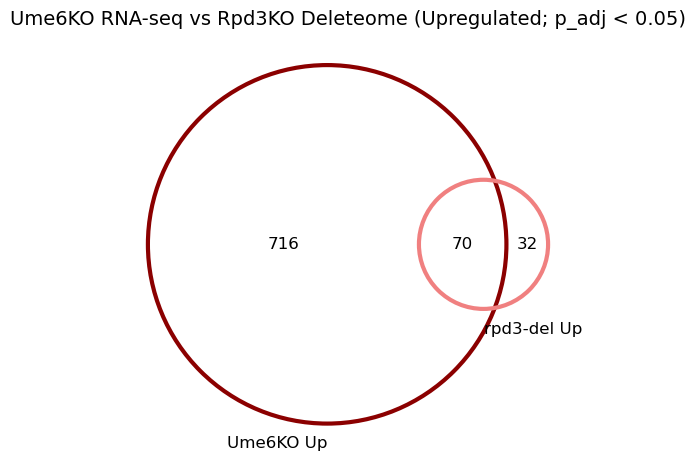

Plotting Venn Diagram for Ume6KO RNA-seq vs Sin3KO Deleteome (Upregulated; p_adj < 0.05):
  Ume6KO Up (size=786): ['YAL061W', 'YBR047W', 'YJL106W', 'YNL293W', 'YGL191W', 'YPR049C', 'YJL099W', 'YDL174C', 'YML101C', 'YJL166W']
  sin3-del Up (size=69): ['YDR360W', 'YHL030W', 'YMR034C', 'YDR034W-B', 'YGL249W', 'YBR047W', 'YJL106W', 'YOL058W', 'YPL111W', 'YDL169C']


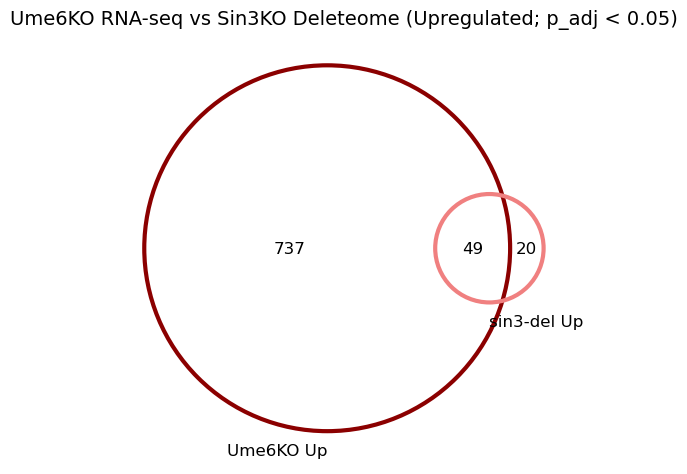

In [10]:
#Ume6KO case: 
ume6_up = set(bulk_rna_up['Ume6KO'].dropna().astype(str))

#Down genes: 
ume6_down = set(bulk_rna_data_down['Ume6KO'].dropna().astype(str))

#Since Deleteome dataset doesn't have Ume6-del, we'd rather compare the Ume6KO RNA-seq signatures with rpd3-del & sin3-del from Deleteome. 
print("Upregulated Genes:")
plot_venn_up(ume6_up, rpd3_del_up, 'Ume6KO Up', 'rpd3-del Up', 'Ume6KO RNA-seq vs Rpd3KO Deleteome (Upregulated; p_adj < 0.05)')
plot_venn_up(ume6_up, sin3_del_up, 'Ume6KO Up', 'sin3-del Up', 'Ume6KO RNA-seq vs Sin3KO Deleteome (Upregulated; p_adj < 0.05)')

Plotting Venn Diagram for Ume6KO RNA-seq vs Rpd3KO Deleteome (Downregulated; p_adj < 0.05):
  Ume6KO Down (size=263): ['YLR156C-A', 'YJR118C', 'YJR030C', 'YPL072W', 'YCR045W-A', 'YBR048W', 'YOR143C', 'YLR216C', 'YLR420W', 'YJR069C']
  rpd3-del Down (size=66): ['YJR161C', 'YNL330C', 'YGR295C', 'YDL246C', 'YCR099C', 'YPR140W', 'YKL219W', 'YLR303W', 'YLR452C', 'YOL159C']


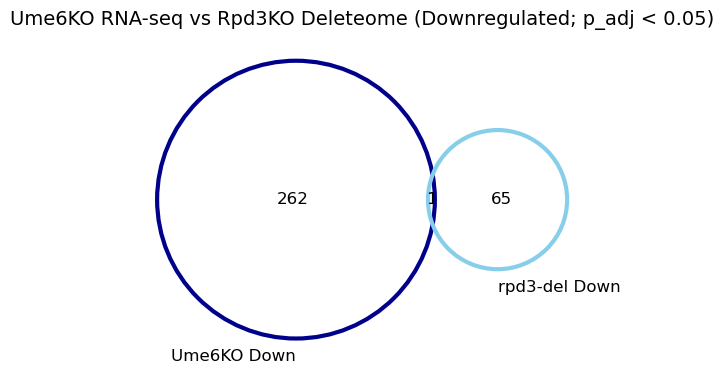

Plotting Venn Diagram for Ume6KO RNA-seq vs Sin3KO Deleteome (Downregulated; p_adj < 0.05):
  Ume6KO Down (size=263): ['YLR156C-A', 'YJR118C', 'YJR030C', 'YPL072W', 'YCR045W-A', 'YBR048W', 'YOR143C', 'YLR216C', 'YLR420W', 'YJR069C']
  sin3-del Down (size=56): ['YJR161C', 'YGR295C', 'YDL246C', 'YCR099C', 'YIL119C', 'YOL159C', 'YLR452C', 'YBR302C', 'YHR184W', 'YOL004W']


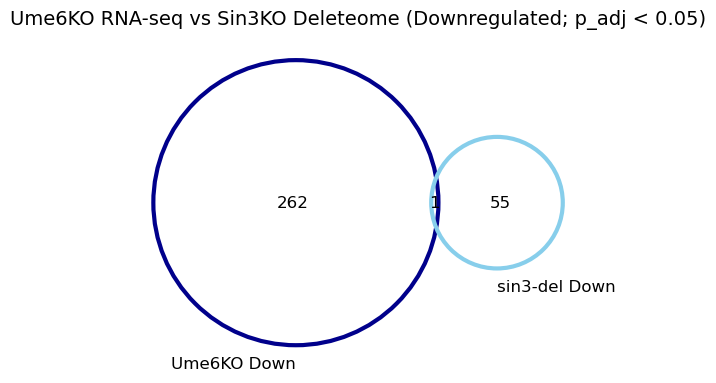

In [11]:
#Down genes: 
plot_venn_down(ume6_down, rpd3_del_down, 'Ume6KO Down', 'rpd3-del Down', 'Ume6KO RNA-seq vs Rpd3KO Deleteome (Downregulated; p_adj < 0.05)')
plot_venn_down(ume6_down , sin3_del_down, 'Ume6KO Down', 'sin3-del Down', 'Ume6KO RNA-seq vs Sin3KO Deleteome (Downregulated; p_adj < 0.05)')

#Julien: see when we use down DEGs, the overlap massively drops! (for up, we still have substantial overlaps) => talking about ume6!! 

In [12]:
red_conditions = [
    'dep1-del vs. wt',
    'pho23-del vs. wt',
    'rpd3-del vs. wt',
    'rxt2-del vs. wt',
    'sap30-del vs. wt',
    'sds3-del vs. wt',
    'sin3-del vs. wt'
]

#Loop through each condition, extract genes & find the intersection
for condition in red_conditions:
    condition_genes = set(map(str, condition_upregulated.get(condition, [])))  #Extract genes per condition
    common_genes = ume6_up & condition_genes  #Find intersection with rpd3_up
    print(f"Condition: {condition}")
    print(f"Common genes: {common_genes}")
    print(f"Number of common genes: {len(common_genes)}")
    print("-" * 50) #print a line of 50 dashes (-) in Python 


Condition: dep1-del vs. wt
Common genes: {'YHL030W', 'YJR095W', 'YMR034C', 'YDR034W-B', 'YGL249W', 'YBR047W', 'YJL106W', 'YPL111W', 'YDL169C', 'YLR446W', 'YKR009C', 'YHR138C', 'YPL119C', 'YDR018C', 'YLR031W', 'YGL183C', 'YGL104C', 'YJL153C', 'YGL205W', 'YOL131W', 'YIL072W', 'YKL086W', 'YIL024C', 'YGR225W', 'YDL199C', 'YDR285W', 'YPL134C', 'YGR149W', 'YLR438W', 'YMR040W', 'YGR110W', 'YHR079C-A', 'YGR131W', 'YGR053C', 'YBR184W', 'YLL046C', 'YML042W', 'YMR191W', 'YDR374C', 'YBR046C', 'YER179W', 'YGL081W', 'YHR014W', 'YEL039C', 'YOR374W', 'YPL017C', 'YKL093W', 'YJL103C', 'YGL156W', 'YJL089W', 'YDR446W'}
Number of common genes: 51
--------------------------------------------------
Condition: pho23-del vs. wt
Common genes: {'YGR149W', 'YGL104C', 'YMR034C', 'YJL153C', 'YDR034W-B', 'YBR047W', 'YMR040W', 'YGR110W', 'YLR446W', 'YDL169C', 'YGR053C', 'YKL093W', 'YGL156W', 'YHR138C', 'YBR085C-A'}
Number of common genes: 15
--------------------------------------------------
Condition: rpd3-del vs. w

In [13]:
from scipy.stats import hypergeom
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [14]:
total_unique_genes = data_pd['geneSymbol'].nunique()
print(f"Total unique genes in Deleteome: {total_unique_genes}")

Total unique genes in Deleteome: 6109


- Hypergeometric test & Representation Factor: A hypergeometric test is a statistical method used to determine the significance of overlap between two sets, such as gene lists. It answers the question: If we randomly selected a certain number of items from a population, what is the probability that we would observe at least as many overlaps as we did? This test is particularly useful in genomics and bioinformatics when comparing gene sets to assess whether the observed overlap is more than would be expected by chance. In our context, the test helps evaluate whether the overlap between the knockout profiles in the deleteome data and the differentially expressed genes in the RNA-seq data is statistically significant.
The probability of finding x overlapping genes can be calculated using the hypergeometric probability formula: C(D, x) * C(N-D, n-x) / C(N,n)

If x is less than the expected number of overlapping genes, the probability of finding x or fewer genes is: Prob = sum (i=0 to i=x) [ C(D, i) * C(N-D, n-i) / C(N,n) ]

If x is greater than the expected number of overlapping genes, the probability of finding x or more genes is: Prob = 1- sum (i=0 to i=(x-1)) [ C(D, i) * C(N-D, n-i) / C(N,n) ]

The representation factor (RF) quantifies the enrichment level of overlap between two sets, calculated as the observed overlap count divided by the expected overlap count (calculated based on the sizes of the gene sets and the total gene pool). An RF > 1 indicates more overlap than expected by chance, suggesting a potential biological relationship between the compared sets. Conversely, an RF < 1 would imply less overlap than expected, which may suggest the sets are not related. RF values help interpret the biological relevance of the overlaps in conjunction with the hypergeometric test's p-value.

Mathematically, RF is the number of overlapping genes divided by the expected number of overlapping genes drawn from two independent groups.

- RF > 1 indicates more overlap than expected of two independent groups,
- RF < 1 indicates less overlap than expected
- RF=1 indicates that the two groups by the number of genes expected for independent groups of genes.


x = # of genes in common between two groups. n = # of genes in group 1. D = # of genes in group 2. N = total genes, in this case the 17611 genes with good spots on the Kim lab full genome chips. C(a,b) is the number of combinations of things taken b at a time.

The representation factor = x / expected #genes. Expected #genes = (n * D) / N

In [15]:
#Total genes assumed for the test
total_genes = total_unique_genes
p_value_threshold = 0.05

#Lists to store results
results_up_list = []
results_down_list = []

#Iterate over all bulk RNA-seq conditions for both up and downregulated data
for bulk_condition in bulk_rna_up.columns:
    # Upregulated genes
    bulk_genes_up = set(bulk_rna_up[bulk_condition].dropna().astype(str))
    for del_condition, deleteome_genes in condition_upregulated.items():
        overlap_up = bulk_genes_up & set(deleteome_genes)
        overlap_count_up = len(overlap_up)
        
        # Hypergeometric test
        M = total_genes
        n = len(deleteome_genes)
        N = len(bulk_genes_up)
        k = overlap_count_up
        p_value_up = hypergeom.sf(k - 1, M, n, N)
        expected_overlap_up = (N * n) / M
        rf_up = overlap_count_up / expected_overlap_up if expected_overlap_up > 0 else float('inf')
        
        if p_value_up < p_value_threshold:
            results_up_list.append({
                'Condition': bulk_condition,
                'Knockout Profile': del_condition,
                'Overlap Count': overlap_count_up,
                'P-value': p_value_up,
                'Representation Factor': rf_up
            })

#Same for downregulated genes
for bulk_condition in bulk_rna_data_down.columns:
    bulk_genes_down = set(bulk_rna_data_down[bulk_condition].dropna().astype(str))
    for del_condition, deleteome_genes in condition_downregulated.items():
        overlap_down = bulk_genes_down & set(deleteome_genes)
        overlap_count_down = len(overlap_down)
        
        # Hypergeometric test
        n = len(deleteome_genes)
        N = len(bulk_genes_down)
        k = overlap_count_down
        p_value_down = hypergeom.sf(k - 1, M, n, N)
        expected_overlap_down = (N * n) / M
        rf_down = overlap_count_down / expected_overlap_down if expected_overlap_down > 0 else float('inf')
        
        if p_value_down < p_value_threshold:
            results_down_list.append({
                'Condition': bulk_condition,
                'Knockout Profile': del_condition,
                'Overlap Count': overlap_count_down,
                'P-value': p_value_down,
                'Representation Factor': rf_down
            })

results_up_df = pd.DataFrame(results_up_list)
results_down_df = pd.DataFrame(results_down_list)

In [16]:
from statsmodels.stats.multitest import multipletests

When tests are not independent, standard FDR correction methods like the Benjamini-Hochberg (BH) approach may not control the false discovery rate adequately because BH assumes independence among tests. The Benjamini-Yekutieli (BY) correction is designed to handle such dependencies by being more conservative. This means that the BY correction lowers the threshold for significance even more than BH, which reduces the number of false positives when tests are dependent but also may reduce the number of significant findings.

For example, in deleteome gene expression profiling, if certain knockout profiles share similar biological pathways or influence overlapping gene networks (which is the case), the test results may show dependencies due to these shared biological programs, making the BY correction more appropriate for controlling false discoveries.

In [17]:
#Do a more conservative Benjamini-Yekutieli (BY) correction:
#This adjustment is particularly useful as our tests are not independent => certain genes are co-expressed or functionally related, 
#so the presence or absence of one gene's differential expression might influence the likelihood of observing similar results in other genes. 
#In this case, testing each gene's differential expression separately might lead to dependencies among the tests.

#Apply BY correction to the p-values in both results_up_df & results_down_df
results_up_df['Adjusted P-value BY'] = multipletests(results_up_df['P-value'], method='fdr_by')[1]
results_down_df['Adjusted P-value BY'] = multipletests(results_down_df['P-value'], method='fdr_by')[1]

#Set FDR threshold
fdr_threshold = 0.05

#Filter based on FDR threshold: 
filtered_up_df = results_up_df[results_up_df['Adjusted P-value BY'] < fdr_threshold]
filtered_down_df = results_down_df[results_down_df['Adjusted P-value BY'] < fdr_threshold]

#Calculate the number of genes filtered out
genes_filtered_up = len(results_up_df) - len(filtered_up_df)
genes_filtered_down = len(results_down_df) - len(filtered_down_df)

print("Number of genes filtered out (Upregulated):", genes_filtered_up)
print("Number of genes filtered out (Downregulated):", genes_filtered_down)

print(filtered_up_df['Condition'].value_counts()) #based on upregulated DEG overlap 

#Previously, 209 KOs overlapped with E6R 

Number of genes filtered out (Upregulated): 381
Number of genes filtered out (Downregulated): 333
Condition
Ume6KO    241
E6R       216
TSA       205
rpd3KO    163
Sin3KO    160
Name: count, dtype: int64


In [18]:
filtered_down_df['Condition'].value_counts() #based on downregulated DEG overlap 

#Previously, 81 KOs overlapped with E6R 

Condition
E6R       89
Ume6KO    68
rpd3KO    66
Sin3KO    56
TSA       39
Name: count, dtype: int64

In [19]:
#Modify the plotting color for the Venn diagram:

def plot_venn_hypergeometric(set1, set2, label1, label2, title, color1='darkred', color2='skyblue'):
    set1 = set(map(str, set1))
    set2 = set(map(str, set2))
    
    print(f"Plotting Venn Diagram for {title}:")
    print(f"  {label1} (size={len(set1)}): {list(set1)[:10]}")
    print(f"  {label2} (size={len(set2)}): {list(set2)[:10]}")

    if len(set1) > 0 and len(set2) > 0:
        plt.figure(figsize=(6, 6))

        # Plot the Venn diagram without fills
        venn = venn2([set1, set2], (label1, label2), set_colors=('white', 'white'))
        
        # Draw custom outlines
        venn_circles = venn2_circles([set1, set2], linestyle='solid', linewidth=3)
        venn_circles[0].set_edgecolor(color1)
        venn_circles[1].set_edgecolor(color2)
        
        # Increase label font size
        for label_id in ('10', '01', '11'):
            label = venn.get_label_by_id(label_id)
            if label:
                label.set_fontsize(12)

        plt.title(title, fontsize=14)
        plt.show()
    else:
        print(f"Skipping {title} due to empty set(s): {label1} size={len(set1)}, {label2} size={len(set2)}")


Plotting Venn Diagram for KO profiles similar to Ume6KO:
  By upregulated DEG overlap (size=241): ['ssn6-del vs. wt', 'thr1-del vs. wt', 'nmd2-del vs. wt', 'rpb9-del vs. wt', 'med2-del vs. wt', 'ynl213c-del vs. wt', 'rtt106-del vs. wt', 'kar3-del vs. wt', 'ptc1-del vs. wt', 'spt8-del vs. wt']
  By downregulated DEG overlap (size=68): ['yhr003c-del vs. wt', 'ssn6-del vs. wt', 'vps16-del vs. wt', 'rpb9-del vs. wt', 'med16-del vs. wt', 'med2-del vs. wt', 'med3-del vs. wt', 'cdc40-del vs. wt', 'ram1-del vs. wt', 'med15-del vs. wt']


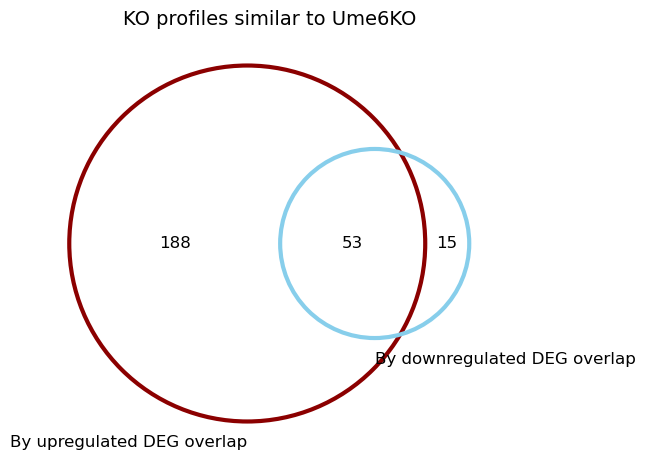

In [20]:
#Ume6KO  Venn for up & down: after 2-step BY-FDR correction 
Ume6KO_up = filtered_up_df[filtered_up_df['Condition']== 'Ume6KO'] 
Ume6KO_down = filtered_down_df[filtered_down_df['Condition']== 'Ume6KO'] 

Ume6KO_del_up = set(map(str, Ume6KO_up.get('Knockout Profile', [])))
Ume6KO_del_down= set(map(str, Ume6KO_down.get('Knockout Profile', [])))

plot_venn_hypergeometric(Ume6KO_del_up, Ume6KO_del_down, 'By upregulated DEG overlap', 'By downregulated DEG overlap', 'KO profiles similar to Ume6KO')

#In the manuscript, we restrict to only up DEGs to restrict to the direct effects of HDAC inhibition. 

In [21]:
#Ume6KO best targets (derived using up & down lists) 
Ume6KO_del_overlap= Ume6KO_del_up.intersection(Ume6KO_del_down) 
Ume6KO_del_overlap

{'ada2-del vs. wt',
 'arg82-del vs. wt',
 'ccr4-del vs. wt',
 'cho2-del vs. wt',
 'cst6-del vs. wt',
 'ctr9-del vs. wt',
 'def1-del vs. wt',
 'doc1-del vs. wt',
 'elp6-del vs. wt',
 'est3-del vs. wt',
 'fkh1-del vs. wt',
 'gcn5-del vs. wt',
 'grr1-del vs. wt',
 'ies6-del vs. wt',
 'ira1-del vs. wt',
 'kem1-del vs. wt',
 'med15-del vs. wt',
 'med16-del vs. wt',
 'med2-del vs. wt',
 'med20-del vs. wt',
 'med3-del vs. wt',
 'ngg1-del vs. wt',
 'not4-del vs. wt',
 'npl3-del vs. wt',
 'npl6-del vs. wt',
 'opi3-del vs. wt',
 'paf1-del vs. wt',
 'rad6-del vs. wt',
 'ram1-del vs. wt',
 'rcy1-del vs. wt',
 'reg1-del vs. wt',
 'rpb9-del vs. wt',
 'sfp1-del vs. wt',
 'sit4-del vs. wt',
 'slx5-del vs. wt',
 'snf12-del vs. wt',
 'snf2-del vs. wt',
 'snf5-del vs. wt',
 'snf6-del vs. wt',
 'snf7-del vs. wt',
 'spt20-del vs. wt',
 'spt3-del vs. wt',
 'spt7-del vs. wt',
 'ssn6-del vs. wt',
 'stp1-del vs. wt',
 'swa2-del vs. wt',
 'swi3-del vs. wt',
 'swi6-del vs. wt',
 'tlc1-del vs. wt',
 'tps2-del vs.

To automate this for all five conditions and save the overlapping knockout (KO) targets (from up & down DEG overlap) into files:

In [22]:
conditions = ['Ume6KO', 'rpd3KO', 'Sin3KO', 'E6R', 'TSA']

best_targets_dict = {}

#Build dictionary of sets (KO overlaps for each condition)
for condition in conditions:
    up_df = filtered_up_df[filtered_up_df['Condition'] == condition]
    down_df = filtered_down_df[filtered_down_df['Condition'] == condition]

    up_kos = set(map(str, up_df.get('Knockout Profile', [])))
    down_kos = set(map(str, down_df.get('Knockout Profile', [])))

    overlap_kos = up_kos & down_kos
    best_targets_dict[condition] = sorted(overlap_kos)  #convert to sorted list for easier export
    print(f" {condition}: {len(overlap_kos)} shared KO targets.")

#Convert to DataFrame (column-wise alignment)
max_len = max(len(v) for v in best_targets_dict.values())

for k in best_targets_dict:
    #Pad with empty strings to equalize lengths
    best_targets_dict[k] += [''] * (max_len - len(best_targets_dict[k]))

best_targets_df = pd.DataFrame(best_targets_dict)

#Save to Excel
#best_targets_df.to_csv("best_KO_targets_by_condition.csv", index=False)
best_targets_df.to_excel("Best_KO_targets_by_condition_11042025.xlsx", index=False)

#In the manuscript, we restrict to only up DEGs to restrict to the direct effects of HDAC inhibition. 

 Ume6KO: 53 shared KO targets.
 rpd3KO: 27 shared KO targets.
 Sin3KO: 24 shared KO targets.
 E6R: 59 shared KO targets.
 TSA: 30 shared KO targets.


Plotting Venn Diagram for KO profiles similar to Ume6KO:
  By upregulated DEG overlap (size=241): ['ssn6-del vs. wt', 'thr1-del vs. wt', 'nmd2-del vs. wt', 'rpb9-del vs. wt', 'med2-del vs. wt', 'ynl213c-del vs. wt', 'rtt106-del vs. wt', 'kar3-del vs. wt', 'ptc1-del vs. wt', 'spt8-del vs. wt']
  By downregulated DEG overlap (size=68): ['yhr003c-del vs. wt', 'ssn6-del vs. wt', 'vps16-del vs. wt', 'rpb9-del vs. wt', 'med16-del vs. wt', 'med2-del vs. wt', 'med3-del vs. wt', 'cdc40-del vs. wt', 'ram1-del vs. wt', 'med15-del vs. wt']


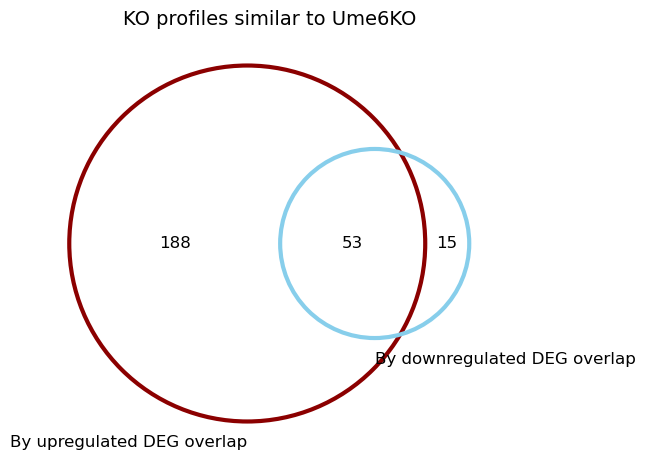

Plotting Venn Diagram for KO profiles similar to rpd3KO:
  By upregulated DEG overlap (size=163): ['ssn6-del vs. wt', 'thr1-del vs. wt', 'rpb9-del vs. wt', 'ynl213c-del vs. wt', 'kar3-del vs. wt', 'ptc1-del vs. wt', 'sis2-del vs. wt', 'med15-del vs. wt', 'vps25-del vs. wt', 'ric1-del vs. wt']
  By downregulated DEG overlap (size=66): ['yhr003c-del vs. wt', 'ybr285w-del vs. wt', 'med2-del vs. wt', 'med3-del vs. wt', 'cdc40-del vs. wt', 'med15-del vs. wt', 'sas5-del vs. wt', 'elp6-del vs. wt', 'htz1-del vs. wt', 'vac8-del vs. wt']


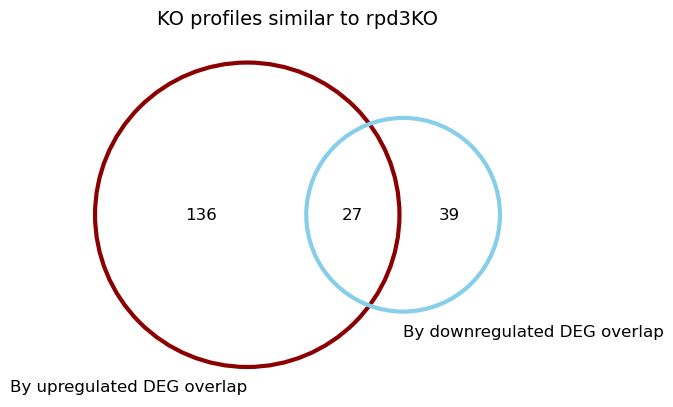

Plotting Venn Diagram for KO profiles similar to Sin3KO:
  By upregulated DEG overlap (size=160): ['ssn6-del vs. wt', 'thr1-del vs. wt', 'rpb9-del vs. wt', 'med2-del vs. wt', 'ynl213c-del vs. wt', 'kar3-del vs. wt', 'ptc1-del vs. wt', 'sis2-del vs. wt', 'med15-del vs. wt', 'rmi1-del vs. wt']
  By downregulated DEG overlap (size=56): ['ybr285w-del vs. wt', 'med2-del vs. wt', 'med3-del vs. wt', 'cdc40-del vs. wt', 'med15-del vs. wt', 'sas5-del vs. wt', 'elp6-del vs. wt', 'htz1-del vs. wt', 'vac8-del vs. wt', 'spt20-del vs. wt']


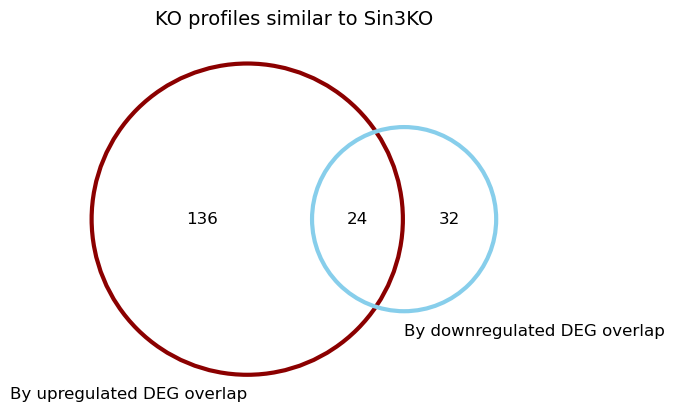

Plotting Venn Diagram for KO profiles similar to E6R:
  By upregulated DEG overlap (size=216): ['ssn6-del vs. wt', 'thr1-del vs. wt', 'rpb9-del vs. wt', 'med2-del vs. wt', 'ynl213c-del vs. wt', 'kar3-del vs. wt', 'ptc1-del vs. wt', 'arx1-del vs. wt', 'car2-del vs. wt', 'eaf7-del vs. wt']
  By downregulated DEG overlap (size=89): ['ssn6-del vs. wt', 'rpb9-del vs. wt', 'leu3-del vs. wt', 'med2-del vs. wt', 'kar3-del vs. wt', 'eaf7-del vs. wt', 'sis2-del vs. wt', 'med15-del vs. wt', 'vps25-del vs. wt', 'hse1-del vs. wt']


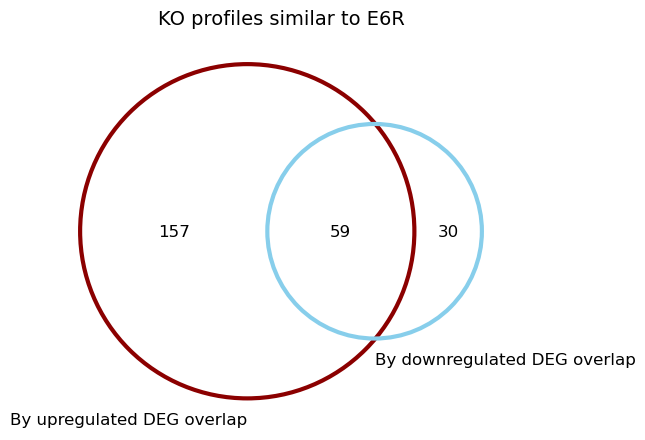

Plotting Venn Diagram for KO profiles similar to TSA:
  By upregulated DEG overlap (size=205): ['yaf9-del vs. wt', 'ssn6-del vs. wt', 'thr1-del vs. wt', 'med2-del vs. wt', 'ynl213c-del vs. wt', 'kar3-del vs. wt', 'ptc1-del vs. wt', 'car2-del vs. wt', 'eaf7-del vs. wt', 'sis2-del vs. wt']
  By downregulated DEG overlap (size=39): ['snt309-del vs. wt', 'rpb9-del vs. wt', 'med16-del vs. wt', 'aco1-del vs. wt', 'cdc40-del vs. wt', 'vps25-del vs. wt', 'spt20-del vs. wt', 'rny1-del vs. wt', 'pho23-del vs. wt', 'pep7-del vs. wt']


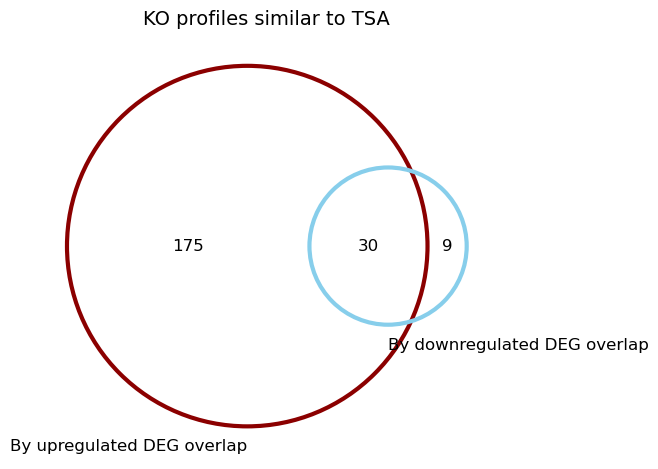

In [23]:
for condition in conditions:
    #Filter up and downregulated DEGs
    up_df = filtered_up_df[filtered_up_df['Condition'] == condition]
    down_df = filtered_down_df[filtered_down_df['Condition'] == condition]
    
    #Extract KO profiles
    up_kos = set(map(str, up_df.get('Knockout Profile', [])))
    down_kos = set(map(str, down_df.get('Knockout Profile', [])))
    
    #Compute intersection
    overlap_kos = up_kos & down_kos
    best_targets_dict[condition] = overlap_kos

    #Plot Venn diagrams for each case 
    plot_venn_hypergeometric(up_kos, down_kos, 'By upregulated DEG overlap', 'By downregulated DEG overlap', f'KO profiles similar to {condition}')

In [25]:
def find_unique_overlaps(df, column_name='Knockout Profile'):
    condition_sets = {cond: set(df[df['Condition'] == cond][column_name]) for cond in df['Condition'].unique()}
    return condition_sets

from matplotlib_venn import venn2, venn3, venn3_circles
from upsetplot import UpSet

#Repeat UpSet plot: 
#After 2-step BY-based FDR correction: 
up_condition_sets = find_unique_overlaps(filtered_up_df)
down_condition_sets = find_unique_overlaps(filtered_down_df)

print("Unique & overlapping knockout profiles (upregulated):")
for cond, profiles in up_condition_sets.items():
    print(f"{cond}: {len(profiles)} unique profiles")

print("\nUnique and overlapping knockout profiles (downregulated):")
for cond, profiles in down_condition_sets.items():
    print(f"{cond}: {len(profiles)} unique profiles")

Unique & overlapping knockout profiles (upregulated):
rpd3KO: 163 unique profiles
Sin3KO: 160 unique profiles
Ume6KO: 241 unique profiles
TSA: 205 unique profiles
E6R: 216 unique profiles

Unique and overlapping knockout profiles (downregulated):
rpd3KO: 66 unique profiles
Sin3KO: 56 unique profiles
Ume6KO: 68 unique profiles
TSA: 39 unique profiles
E6R: 89 unique profiles


Below is the modified plot_upset() function that takes a bar_color argument so we can color the upregulated overlaps in red & downregulated overlaps in blue:

In [26]:
from upsetplot import from_contents, UpSet
import matplotlib.pyplot as plt

def plot_upset(sets, title="Overlap of Knockout Profiles", filename=None, bar_color='black'):
    contents = from_contents(sets)

    #Create UpSet object with manual color setup
    upset = UpSet(
        contents,
        subset_size='count',
        show_counts='%d',
        sort_categories_by=None,
        element_size=40,
        facecolor=bar_color  #Set bar color here
    )

    fig = plt.figure(figsize=(10, 5))
    upset.plot(fig=fig)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()

    if filename:
        plt.savefig(filename, bbox_inches='tight', format='pdf')
        print(f" Saved plot as: {filename}")
    plt.show()


/home/olive0927/miniconda3/envs/scRNAseq_core_analysis/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/olive0927/miniconda3/envs/scRNAseq_core_analysis/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace

 Saved plot as: KO_up_overlap_upsetplot_11042025.pdf


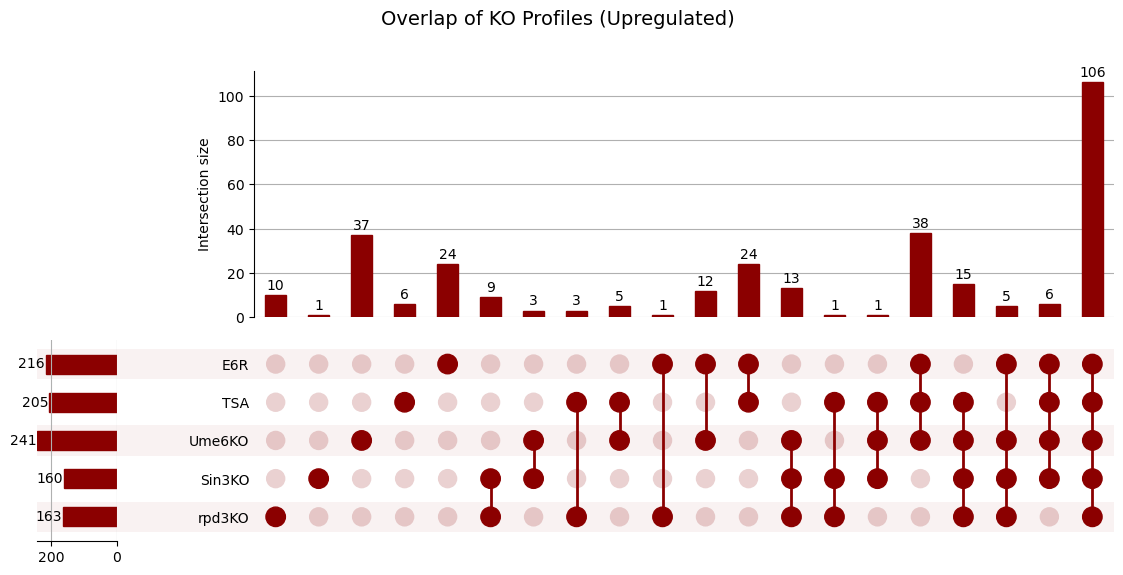

 Saved plot as: KO_down_overlap_upsetplot_11042025.pdf


/home/olive0927/miniconda3/envs/scRNAseq_core_analysis/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/olive0927/miniconda3/envs/scRNAseq_core_analysis/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace

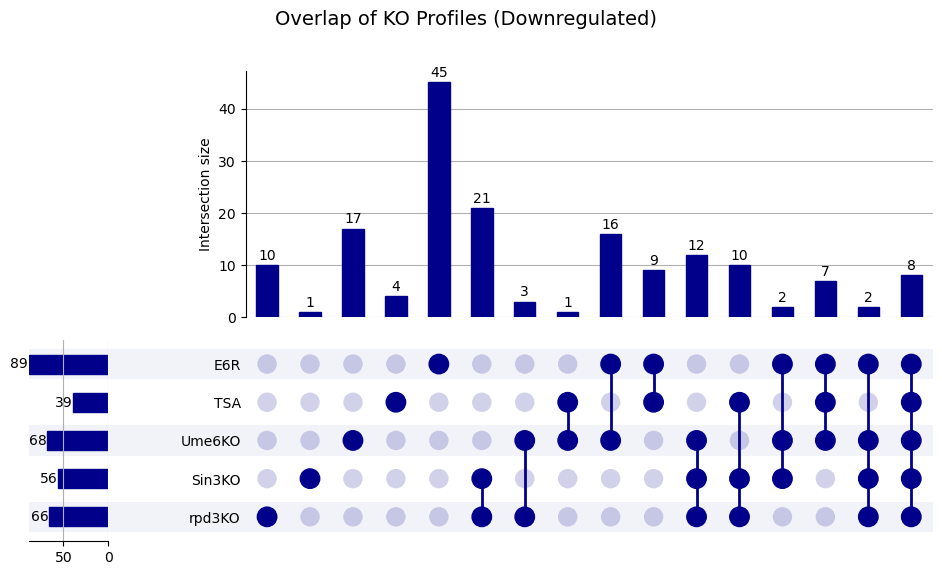

In [28]:
#Red for upregulated: also in Figure S5 
plot_upset(
    up_condition_sets,
    title="Overlap of KO Profiles (Upregulated)",
    filename="KO_up_overlap_upsetplot_11042025.pdf",
    bar_color='darkred'
)

#Blue for downregulated
plot_upset(
    down_condition_sets,
    title="Overlap of KO Profiles (Downregulated)",
    filename="KO_down_overlap_upsetplot_11042025.pdf",
    bar_color='darkblue'
)

#Using down DEGs for overlap, we got only 8 shared targets (KO profiles), but up gives 106. How reliable is this?! Up DEGs indicate more direct effects
#of HDAC inhibition. 

In [29]:
print(bulk_rna_up.head())

print(bulk_rna_data_down.head()) 

      rpd3KO     Sin3KO     Ume6KO        TSA      E6R
0    YBR116C  YHR079C-A  YHR079C-A    YBR116C  YGR224W
1  YHR079C-A    YJR095W    YDR374C    YDR360W  YLL056C
2    YJR095W    YBL065W    YOL131W    YLR445W  YGR035C
3    YLR445W    YBR116C    YLL030C  YHR079C-A  YPL088W
4    YBL065W    YLR445W    YOR351C    YNL019C  YLR046C
    rpd3KO   Sin3KO   Ume6KO      TSA        E6R
0  YGR008C  YCR097W  YOR143C  YKL120W    YAL025C
1  YMR205C  YOR047C  YGR159C  YGR118W    YDR299W
2  YBR240C  YDR234W  YGL111W  YBR137W    YCR072C
3  YMR316W  YJL216C  YPR102C  YDR482C    YPL043W
4  YDR185C  YDR096W  YMR250W  YBR177C  YCR020W-B


In [31]:
#To store the overlaps 
output_up = []
output_down = []

#Extract the up & down DEGs from JO's bulk RNA-seq data: 
Ume6KO_up = set(bulk_rna_up['Ume6KO'].dropna().astype(str))
Ume6KO_down = set(bulk_rna_data_down['Ume6KO'].dropna().astype(str))

for condition in Ume6KO_del_overlap:

    #Extract DEGs from each of the gene-del vs wt conditions listed in "E6R_del_overlap" 
    condition_up = set(map(str, condition_upregulated.get(condition, [])))
    condition_down = set(map(str, condition_downregulated.get(condition, [])))

    #After that, we take an overlap with JO's RNA-seq data 
    Ume6KO_up_overlap = Ume6KO_up.intersection(condition_up)
    Ume6KO_down_overlap = Ume6KO_down.intersection(condition_down)


    if Ume6KO_up_overlap:
        output_up.append({
            'Case': 'Ume6KO_up',
            'Condition': condition,
            'Overlap Count': len(Ume6KO_up_overlap), 
            'Overlap Targets': list(Ume6KO_up_overlap)  #Convert set to list
            
        })

    if Ume6KO_down_overlap:
        output_down.append({
            'Case': 'Ume6KO_down',
            'Condition': condition,
            'Overlap Count': len(Ume6KO_down_overlap), 
            'Overlap Targets': list(Ume6KO_down_overlap)  #Convert set to list
            
        })

#sort by descending order of overlap count
df_up = pd.DataFrame(output_up).sort_values(by='Overlap Count', ascending=False)
df_down = pd.DataFrame(output_down).sort_values(by='Overlap Count', ascending=False)

In [32]:
df_up.head()

,Case,Condition,Overlap Count,Overlap Targets
0,Ume6KO_up,ssn6-del vs. wt,216,"[YBR114W, YOR328W, YAL061W, YLR012C, YOL159C, ..."
15,Ume6KO_up,opi3-del vs. wt,165,"[YJR095W, YAL061W, YOL159C, YER054C, YDL169C, ..."
19,Ume6KO_up,kem1-del vs. wt,135,"[YJR161C, YAL061W, YJL106W, YER054C, YIL165C, ..."
24,Ume6KO_up,grr1-del vs. wt,131,"[YGL125W, YJR095W, YHR054C, YAL061W, YBR047W, ..."
6,Ume6KO_up,ram1-del vs. wt,122,"[YAL061W, YER054C, YDL174C, YDL169C, YKL163W, ..."


In [33]:
df_down.head()

,Case,Condition,Overlap Count,Overlap Targets
15,Ume6KO_down,opi3-del vs. wt,40,"[YNL141W, YER124C, YPL043W, YOR315W, YBR092C, ..."
29,Ume6KO_down,spt7-del vs. wt,31,"[YGR086C, YOR161C, YBR158W, YDR033W, YER001W, ..."
10,Ume6KO_down,spt20-del vs. wt,29,"[YMR319C, YBR158W, YDR033W, YNL141W, YDR297W, ..."
7,Ume6KO_down,med15-del vs. wt,28,"[YGR086C, YOR161C, YBR158W, YDR033W, YCR024C-A..."
2,Ume6KO_down,rpb9-del vs. wt,27,"[YOR161C, YER001W, YNL141W, YER124C, YER060W-A..."


In [34]:
#Load Excel with each sheet as a condition
file_path = "DESeq2_DEGs_yeast_09042025.xlsx"

Ume6KO_df = pd.read_excel(file_path, sheet_name='Ume6KO_DEGs')
Ume6KO_df.head()

#Filter rows with adjusted p-value (padj) < 0.05
significant_degs = Ume6KO_df[Ume6KO_df['padj'] < 0.05]
len(significant_degs)

1049

In [35]:
#Make a dictionary of significant log2FC & padj for DEGs: 
log2fc_dict = significant_degs.set_index('Systematic Name')['log2FoldChange'].to_dict()
padj_dict = significant_degs.set_index('Systematic Name')['padj'].to_dict()

In [36]:
#Extract Ume6KO condition from hypergeometric results: 
Ume6KO_up_hypergeom = filtered_up_df[filtered_up_df['Condition']== 'Ume6KO'] 
Ume6KO_down_hypergeom = filtered_down_df[filtered_down_df['Condition']== 'Ume6KO'] 

print(Ume6KO_up_hypergeom.head())
print(Ume6KO_down_hypergeom.head())

    Condition  Knockout Profile  Overlap Count       P-value  \
464    Ume6KO   ptc1-del vs. wt             84  5.255185e-37   
465    Ume6KO   tlc1-del vs. wt            109  9.754885e-28   
466    Ume6KO   nth2-del vs. wt              5  5.846482e-04   
467    Ume6KO   swa2-del vs. wt             88  9.061966e-27   
468    Ume6KO  rad18-del vs. wt             11  2.733280e-05   

     Representation Factor  Adjusted P-value BY  
464               4.323644         1.332691e-34  
465               2.891389         1.340466e-25  
466               5.551618         7.862491e-03  
467               3.256949         1.177062e-24  
468               3.886132         4.695514e-04  
    Condition    Knockout Profile  Overlap Count       P-value  \
227    Ume6KO     tlc1-del vs. wt             13  7.724510e-14   
230    Ume6KO     swa2-del vs. wt              6  4.201019e-04   
231    Ume6KO    vps16-del vs. wt              8  1.378907e-04   
233    Ume6KO     sfp1-del vs. wt             21  5

In [38]:
#Step 1: Prepare Enrichment data from hypergeometric analysis
enrichment_up = Ume6KO_up_hypergeom[['Knockout Profile', 'Representation Factor', 'Adjusted P-value BY']]
enrichment_down = Ume6KO_down_hypergeom[['Knockout Profile', 'Representation Factor', 'Adjusted P-value BY']]

#Rename columns for clarity
enrichment_up = enrichment_up.rename(columns={
    'Knockout Profile': 'Condition',
    'Representation Factor': 'Representation Factor',
    'Adjusted P-value BY': 'Adj_P_Val'
})

enrichment_down = enrichment_down.rename(columns={
    'Knockout Profile': 'Condition',
    'Representation Factor': 'Representation Factor',
    'Adjusted P-value BY': 'Adj_P_Val'
})

#Step 2: Merge enrichment data with df_up & df_down
df_up = df_up.merge(enrichment_up, on='Condition', how='left')
df_down = df_down.merge(enrichment_down, on='Condition', how='left')

df_up.head()

,Case,Condition,Overlap Count,Overlap Targets,Representation Factor,Adj_P_Val
0,Ume6KO_up,ssn6-del vs. wt,216,"[YBR114W, YOR328W, YAL061W, YLR012C, YOL159C, ...",2.563067,4.346283e-44
1,Ume6KO_up,opi3-del vs. wt,165,"[YJR095W, YAL061W, YOL159C, YER054C, YDL169C, ...",2.954893,2.003010e-41
2,Ume6KO_up,kem1-del vs. wt,135,"[YJR161C, YAL061W, YJL106W, YER054C, YIL165C, ...",2.406550,4.191659e-23
3,Ume6KO_up,grr1-del vs. wt,131,"[YGL125W, YJR095W, YHR054C, YAL061W, YBR047W, ...",3.242569,3.217664e-37
4,Ume6KO_up,ram1-del vs. wt,122,"[YAL061W, YER054C, YDL174C, YDL169C, YKL163W, ...",2.882116,1.075572e-28


In [39]:
df_down.head()

,Case,Condition,Overlap Count,Overlap Targets,Representation Factor,Adj_P_Val
0,Ume6KO_down,opi3-del vs. wt,40,"[YNL141W, YER124C, YPL043W, YOR315W, YBR092C, ...",5.631063,2.317634e-17
1,Ume6KO_down,spt7-del vs. wt,31,"[YGR086C, YOR161C, YBR158W, YDR033W, YER001W, ...",4.444890,1.394620e-10
2,Ume6KO_down,spt20-del vs. wt,29,"[YMR319C, YBR158W, YDR033W, YNL141W, YDR297W, ...",4.132613,4.087610e-09
3,Ume6KO_down,med15-del vs. wt,28,"[YGR086C, YOR161C, YBR158W, YDR033W, YCR024C-A...",8.129848,2.490129e-16
4,Ume6KO_down,rpb9-del vs. wt,27,"[YOR161C, YER001W, YNL141W, YER124C, YER060W-A...",6.399589,5.126449e-13


In [40]:
!mkdir Ume6KO_target_lists_11042025

In [41]:
#Step 4: Save the updated DataFrames
output_file = "./Ume6KO_target_lists_11042025/53KO_Ume6KO_targets_enrichment_11042025.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='53KO_Shared_Upregulated')
    df_down.to_excel(writer, index=False, sheet_name='53KO_Shared_Downregulated')


print(f"Excel file saved as {output_file}")

Excel file saved as ./Ume6KO_target_lists_11042025/53KO_Ume6KO_targets_enrichment_11042025.xlsx


In [42]:
#Now let's read this file:
file_path = './Ume6KO_target_lists_11042025/53KO_Ume6KO_targets_enrichment_11042025.xlsx'


Ume6KO_up_df = pd.read_excel(file_path, sheet_name= '53KO_Shared_Upregulated')
Ume6KO_down_df = pd.read_excel(file_path, sheet_name= '53KO_Shared_Downregulated')

len(Ume6KO_up_df)

53

In [43]:
#Define a function to map log2FC & padj for a list of genes
def map_degs(overlap_targets, condition):
    result = []
    for gene in overlap_targets:
        result.append({
            'Gene': gene,
            'Condition': condition,
            'log2FoldChange': log2fc_dict.get(gene, None),  #Get log2FC or None if not found
            'padj': padj_dict.get(gene, None)  #Get padj or None if not found
        })
    return result


#Process 'Ume6KO_up_df' & 'Ume6KO_down_df' 
output_data = []

for _, row in Ume6KO_up_df.iterrows():
    overlap_genes = eval(row['Overlap Targets'])  #Convert string to list of genes
    output_data.extend(map_degs(overlap_genes, row['Condition']))

for _, row in Ume6KO_down_df.iterrows():
    overlap_genes = eval(row['Overlap Targets'])  #Convert string to list of genes
    output_data.extend(map_degs(overlap_genes, row['Condition']))


output_df = pd.DataFrame(output_data)
output_df.head() #looks great! 

,Gene,Condition,log2FoldChange,padj
0,YBR114W,ssn6-del vs. wt,2.474547,2.830000e-214
1,YOR328W,ssn6-del vs. wt,2.125579,2.070000e-82
2,YAL061W,ssn6-del vs. wt,1.395577,2.270000e-21
3,YLR012C,ssn6-del vs. wt,3.287030,8.344982e-03
4,YOL159C,ssn6-del vs. wt,1.450442,2.350000e-32


In [44]:
#Fix the sorting by log2FC here:
#Some values might be actual lists, others might be strings representing lists: use eval() to convert to lists 

#Function to safely convert "Overlap Targets" into a list
def parse_overlap_targets(overlap_targets):
    """
    Ensure 'Overlap Targets' is properly converted to a list of gene names.
    """
    if isinstance(overlap_targets, str):  # If it's a string, convert it
        try:
            overlap_targets = eval(overlap_targets)  # Convert string to list safely
        except:
            overlap_targets = overlap_targets.strip("[]").replace("'", "").split(", ")
    return [gene.strip() for gene in overlap_targets]  # Remove extra spaces

#Function to sort genes by log2FC
def sort_genes_by_log2fc(overlap_targets, log2fc_dict):
    """
    Sort genes in descending order of log2FoldChange.
    """
    overlap_targets = parse_overlap_targets(overlap_targets)  # Ensure it's a list
    genes_with_fc = [(gene, log2fc_dict.get(gene, 0)) for gene in overlap_targets]
    sorted_genes = sorted(genes_with_fc, key=lambda x: x[1], reverse=True)  # Sort by log2FC
    return [gene[0] for gene in sorted_genes]  # Return sorted gene names

#Function to update the DataFrame with sorted genes
def update_overlap_targets(df, log2fc_dict):
    """
    Update the Overlap Targets column with genes sorted by log2FoldChange.
    """
    df['Overlap Targets'] = df['Overlap Targets'].apply(
        lambda x: ', '.join(sort_genes_by_log2fc(x, log2fc_dict)) if isinstance(x, str) or isinstance(x, list) else x
    )
    return df

#Apply sorting to df_up & df_down (in descending order of log2FC)
df_up = update_overlap_targets(df_up, log2fc_dict)
df_down = update_overlap_targets(df_down, log2fc_dict)

In [45]:
df_up.head()

,Case,Condition,Overlap Count,Overlap Targets,Representation Factor,Adj_P_Val
0,Ume6KO_up,ssn6-del vs. wt,216,"YJL153C, YDR034W-B, YHL024W, YKL217W, YGL262W,...",2.563067,4.346283e-44
1,Ume6KO_up,opi3-del vs. wt,165,"YJR095W, YJL153C, YAL054C, YDR034W-B, YGL205W,...",2.954893,2.003010e-41
2,Ume6KO_up,kem1-del vs. wt,135,"YOR100C, YDR034W-B, YGL205W, YMR107W, YMR322C,...",2.406550,4.191659e-23
3,Ume6KO_up,grr1-del vs. wt,131,"YJR095W, YCR010C, YOR100C, YJL153C, YAL054C, Y...",3.242569,3.217664e-37
4,Ume6KO_up,ram1-del vs. wt,122,"YAL054C, YDR034W-B, YHL024W, YGL205W, YMR107W,...",2.882116,1.075572e-28


In [46]:
df_down.head() 

,Case,Condition,Overlap Count,Overlap Targets,Representation Factor,Adj_P_Val
0,Ume6KO_down,opi3-del vs. wt,40,"YCR072C, YBR247C, YHR068W, YOR224C, YOR340C, Y...",5.631063,2.317634e-17
1,Ume6KO_down,spt7-del vs. wt,31,"YGR159C, YKL096W, YNL066W, YGR086C, YGL037C, Y...",4.444890,1.394620e-10
2,Ume6KO_down,spt20-del vs. wt,29,"YGR159C, YDR297W, YIL158W, YNL066W, YHL028W, Y...",4.132613,4.087610e-09
3,Ume6KO_down,med15-del vs. wt,28,"YNL300W, YJL078C, YKL096W, YPR149W, YJL190C, Y...",8.129848,2.490129e-16
4,Ume6KO_down,rpb9-del vs. wt,27,"YGR159C, YJL078C, YER131W, YKL096W, YER124C, Y...",6.399589,5.126449e-13


In [47]:
#Rewrite the file after correct sorting: 
output_file = "./Ume6KO_target_lists_11042025/53KO_Ume6KO_targets_enrichment_11042025.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='53KO_Shared_Upregulated')
    df_down.to_excel(writer, index=False, sheet_name='53KO_Shared_Downregulated')


print(f"Excel file saved as {output_file}")

Excel file saved as ./Ume6KO_target_lists_11042025/53KO_Ume6KO_targets_enrichment_11042025.xlsx


In [48]:
#List the DEGs dysregulated in all the 53 KO conditions: 

def get_dysregulated_genes(output_df, min_conditions=0):
    #Group by gene & count unique conditions for DEGs 
    gene_condition_counts = output_df.groupby(['Gene', 'log2FoldChange']).Condition.nunique()


    upregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') > 0]
    downregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') < 0]

    #Filter genes dysregulated in at least `min_conditions`
    upregulated_genes = upregulated_genes[upregulated_genes >= min_conditions].sort_values(ascending=False)
    downregulated_genes = downregulated_genes[downregulated_genes >= min_conditions].sort_values(ascending=False)

    
    upregulated_genes_df = pd.DataFrame({'Gene': upregulated_genes.index.get_level_values('Gene'), 
                                         'Conditions': upregulated_genes.values})
    downregulated_genes_df = pd.DataFrame({'Gene': downregulated_genes.index.get_level_values('Gene'), 
                                           'Conditions': downregulated_genes.values})

    return upregulated_genes_df, downregulated_genes_df


upregulated_genes_df, downregulated_genes_df = get_dysregulated_genes(output_df, min_conditions=5)

In [49]:
#Corrected code: 

#We want to tabulate log2FC, adjusted p-value & mention which conditions show dysregulations of these DEGs 
#Save it in the Same Excel file later 

def get_detailed_dysregulated_genes(output_df, min_conditions=0):
    
    gene_condition_counts = output_df.groupby(['Gene', 'log2FoldChange']).Condition.nunique()

    
    upregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') > 0]
    downregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') < 0]

    #Filter genes dysregulated in at least `min_conditions`
    upregulated_genes = upregulated_genes[upregulated_genes >= min_conditions]
    downregulated_genes = downregulated_genes[downregulated_genes >= min_conditions]

    #Extract detailed information (conditions, log2FC, padj)
    up_details = output_df[output_df['Gene'].isin(upregulated_genes.index.get_level_values('Gene')) & 
                           (output_df['log2FoldChange'] > 0)]
    down_details = output_df[output_df['Gene'].isin(downregulated_genes.index.get_level_values('Gene')) & 
                             (output_df['log2FoldChange'] < 0)]

    return up_details, down_details


up_details_df, down_details_df = get_detailed_dysregulated_genes(output_df, min_conditions=0)

up_details_df.head()

,Gene,Condition,log2FoldChange,padj
0,YBR114W,ssn6-del vs. wt,2.474547,2.830000e-214
1,YOR328W,ssn6-del vs. wt,2.125579,2.070000e-82
2,YAL061W,ssn6-del vs. wt,1.395577,2.270000e-21
3,YLR012C,ssn6-del vs. wt,3.287030,8.344982e-03
4,YOL159C,ssn6-del vs. wt,1.450442,2.350000e-32


In [50]:
#Fixed: rank the condition w.t.t descending order of dysregulations 

def get_detailed_dysregulated_genes(output_df, min_conditions=0):
    """
    Extract upregulated and downregulated genes across conditions,
    ensuring sorting within each condition by log2FoldChange.
    """
    
    gene_condition_counts = output_df.groupby(['Gene', 'log2FoldChange']).Condition.nunique()
    upregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') > 0]
    downregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') < 0]

    
    upregulated_genes = upregulated_genes[upregulated_genes >= min_conditions]
    downregulated_genes = downregulated_genes[downregulated_genes >= min_conditions]

   
    up_details = output_df[output_df['Gene'].isin(upregulated_genes.index.get_level_values('Gene')) & 
                           (output_df['log2FoldChange'] > 0)]
    down_details = output_df[output_df['Gene'].isin(downregulated_genes.index.get_level_values('Gene')) & 
                             (output_df['log2FoldChange'] < 0)]

    #Step 1: Count DEGs per condition
    condition_deg_counts = up_details['Condition'].value_counts().to_dict()
    
    #Step 2: Sort by condition-wise DEG count (descending) & log2FC within each condition
    up_details['Condition_DEG_Count'] = up_details['Condition'].map(condition_deg_counts)
    up_details = up_details.sort_values(['Condition_DEG_Count', 'Condition', 'log2FoldChange'], ascending=[False, True, False])
    up_details = up_details.drop(columns=['Condition_DEG_Count'])  # Remove temporary column
    
    condition_deg_counts_down = down_details['Condition'].value_counts().to_dict()
    down_details['Condition_DEG_Count'] = down_details['Condition'].map(condition_deg_counts_down)
    down_details = down_details.sort_values(['Condition_DEG_Count', 'Condition', 'log2FoldChange'], ascending=[False, True, False])
    down_details = down_details.drop(columns=['Condition_DEG_Count'])  # Remove temporary column

    return up_details, down_details

#Apply sorting for upregulated and downregulated genes
up_details_df, down_details_df = get_detailed_dysregulated_genes(output_df, min_conditions=0)
up_details_df.head() #looks good! 

/tmp/ipykernel_210718/3574036871.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_details['Condition_DEG_Count'] = up_details['Condition'].map(condition_deg_counts)
/tmp/ipykernel_210718/3574036871.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_details['Condition_DEG_Count'] = down_details['Condition'].map(condition_deg_counts_down)


,Gene,Condition,log2FoldChange,padj
59,YJL153C,ssn6-del vs. wt,7.450959,0.000000e+00
106,YDR034W-B,ssn6-del vs. wt,5.877872,6.380000e-137
149,YHL024W,ssn6-del vs. wt,5.468396,0.000000e+00
193,YKL217W,ssn6-del vs. wt,5.413373,0.000000e+00
113,YGL262W,ssn6-del vs. wt,5.230775,8.730380e-04


In [51]:
down_details_df.head() 

,Gene,Condition,log2FoldChange,padj
2834,YCR072C,opi3-del vs. wt,-1.017946,2.880000e-47
2839,YBR247C,opi3-del vs. wt,-1.043212,9.040000e-49
2824,YHR068W,opi3-del vs. wt,-1.046273,8.480000e-60
2823,YOR224C,opi3-del vs. wt,-1.050059,5.750000e-46
2819,YOR340C,opi3-del vs. wt,-1.056375,1.240000e-46


In [52]:
#Save the final file with 4 sheets (Shared Up, Shared Down, Up Details, Down Details) => Julien wants this! 
output_file = "./Ume6KO_target_lists_11042025/53KO_Ume6KO_targets_enrichment_11042025.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='53KO_Shared_Upregulated')
    df_down.to_excel(writer, index=False, sheet_name='53KO_Shared_Downregulated')
    up_details_df.to_excel(writer, index=False, sheet_name= 'Upregulated_DEGs_log2FC')
    down_details_df.to_excel(writer, index=False, sheet_name='Downregulated_DEGs_log2FC')

print(f"Excel file saved as {output_file}")

Excel file saved as ./Ume6KO_target_lists_11042025/53KO_Ume6KO_targets_enrichment_11042025.xlsx


In [53]:
def find_unique_overlaps(df, column_name='Knockout Profile'):
    """
    Extracts DEGs for each condition from the dataframe.
    """
    return {cond: set(df[df['Condition'] == cond][column_name]) for cond in df['Condition'].unique()}

#Extract DEGs for all conditions
up_condition_sets = find_unique_overlaps(filtered_up_df)

#Define all four conditions from the Upset plot
conditions = ['E6R', 'TSA', 'rpd3KO', 'Sin3KO', 'Ume6KO']

#Extract upregulated genes for each condition
all_up_genes = {cond: set(filtered_up_df[filtered_up_df['Condition'] == cond]['Knockout Profile']) for cond in conditions}

#Step 1: Extract **all** E6R upregulated genes
Ume6KO_up_genes = all_up_genes['Ume6KO']

#Step 2: Extract shared genes (found in all 4 conditions)
shared_up = set.intersection(*[all_up_genes[cond] for cond in conditions])

#Step 3: Find genes unique to E6R (not found in TSA, rpd3KO, Sin3KO & Ume6KO)
unique_up = Ume6KO_up_genes - set.union(all_up_genes['TSA'], all_up_genes['E6R'], all_up_genes['rpd3KO'], all_up_genes['Sin3KO'])
len(unique_up) #tally this from Upset plot; there are 24 targets (enriched KO profiles) unique to E6R; not shared with anything 

37

In [54]:
#Step 4: Find partially shared genes (found in E6R & at least one other condition, but not all 4)
partially_shared_up = Ume6KO_up_genes - unique_up - shared_up
len(partially_shared_up)

98

In [55]:
unique_up #list all targets

{'arg82-del vs. wt',
 'bmh1-del vs. wt',
 'bud20-del vs. wt',
 'cdh1-del vs. wt',
 'deg1-del vs. wt',
 'ecm30-del vs. wt',
 'elp6-del vs. wt',
 'fkh1-del vs. wt',
 'gtr1-del vs. wt',
 'hcr1-del vs. wt',
 'hst1-del vs. wt',
 'ltv1-del vs. wt',
 'med20-del vs. wt',
 'msn5-del vs. wt',
 'nam7-del vs. wt',
 'nmd2-del vs. wt',
 'npt1-del vs. wt',
 'poc4-del vs. wt',
 'rfm1-del vs. wt',
 'rtg1-del vs. wt',
 'rtg2-del vs. wt',
 'rtt106-del vs. wt',
 'sam1-del vs. wt',
 'ser2-del vs. wt',
 'sgf29-del vs. wt',
 'snf5-del vs. wt',
 'spt3-del vs. wt',
 'spt8-del vs. wt',
 'sum1-del vs. wt',
 'tco89-del vs. wt',
 'tps2-del vs. wt',
 'ubp15-del vs. wt',
 'upf3-del vs. wt',
 'ure2-del vs. wt',
 'ypt7-del vs. wt',
 'yvh1-del vs. wt',
 'zwf1-del vs. wt'}

In [56]:
print(len(shared_up)) #looks correct 
print(len(unique_up))
print(len(partially_shared_up)) 

106
37
98


In [57]:
#Step 5: Store results

categorized_results = {
    "Condition": [], "Category": [], "Contributing Cases": []
}

for gene in shared_up:
    categorized_results["Condition"].append(gene)  #Previously "Gene"
    categorized_results["Category"].append("Shared Upregulated")
    categorized_results["Contributing Cases"].append(", ".join(conditions))  #All 4 conditions

for gene in unique_up:
    categorized_results["Condition"].append(gene)
    categorized_results["Category"].append("Unique Upregulated")
    categorized_results["Contributing Cases"].append("Ume6KO")  #Only in Ume6KO

for gene in partially_shared_up:
    shared_conditions = [cond for cond in conditions if gene in all_up_genes[cond]]  #Find where it is shared
    categorized_results["Condition"].append(gene)
    categorized_results["Category"].append("Partially Shared Upregulated")
    categorized_results["Contributing Cases"].append(", ".join(shared_conditions))  #List only shared conditions


df_categorized = pd.DataFrame(categorized_results)

#Check the #DEGs in each category
print("Total Shared Upregulated Genes:", len(shared_up))
print("Total Unique Upregulated Genes:", len(unique_up))
print("Total Partially Shared Upregulated Genes:", len(partially_shared_up))
print("Total Genes Categorized:", len(df_categorized)) #looks correct!! 

#Save categorized E6R upregulated genes
output_file = "./Ume6KO_target_lists_11042025/Ume6KO_upregulated_targets_classification_11042025.xlsx"
df_categorized.to_excel(output_file, index=False, sheet_name='Ume6KO_Upregulated')

print(f"Excel file saved as {output_file}")

Total Shared Upregulated Genes: 106
Total Unique Upregulated Genes: 37
Total Partially Shared Upregulated Genes: 98
Total Genes Categorized: 241
Excel file saved as ./Ume6KO_target_lists_11042025/Ume6KO_upregulated_targets_classification_11042025.xlsx


In [58]:
all_conditions = set(df_categorized['Condition'].unique())  #Extract all 216 conditions
len(all_conditions)

241

In [60]:
#Repeat the same as above, but with 241 conditions- we need 8 sheets in the Excel file. 

Ume6KO_up = set(bulk_rna_up['Ume6KO'].dropna().astype(str))

#Step 3: Store overlap results
output_up = []

#Step 4: Loop through **each** condition and extract overlaps with E6R_up
for condition in all_conditions:
    
    #Extract DEGs for the current condition
    condition_up = set(map(str, condition_upregulated.get(condition, [])))

    #Find overlap with E6R upregulated genes
    Ume6KO_up_overlap = Ume6KO_up.intersection(condition_up)

    #Store results for upregulated overlaps
    if Ume6KO_up_overlap:
        output_up.append({
            'Case': 'Ume6KO_up',
            'Condition': condition,
            'Overlap Count': len(Ume6KO_up_overlap), 
            'Overlap Targets': list(Ume6KO_up_overlap)  # Convert set to list
        })

#Convert results to DataFrame & sort by descending overlap count
df_up = pd.DataFrame(output_up).sort_values(by='Overlap Count', ascending=False)

#Step 5: **Merge "Category" & "Contributing Cases"** from the categorized file
df_up = df_up.merge(df_categorized, on="Condition", how="left")
df_up.head() 

#Apply sorting to df_up
df_up = update_overlap_targets(df_up, log2fc_dict)
print(df_up)

          Case        Condition  Overlap Count  \
0    Ume6KO_up  ssn6-del vs. wt            216   
1    Ume6KO_up  opi3-del vs. wt            165   
2    Ume6KO_up  tup1-del vs. wt            157   
3    Ume6KO_up  kem1-del vs. wt            135   
4    Ume6KO_up   cap-del vs. wt            135   
..         ...              ...            ...   
236  Ume6KO_up  fkh1-del vs. wt              4   
237  Ume6KO_up  ypt7-del vs. wt              3   
238  Ume6KO_up  poc4-del vs. wt              3   
239  Ume6KO_up  stb4-del vs. wt              3   
240  Ume6KO_up  ltv1-del vs. wt              3   

                                       Overlap Targets  \
0    YJL153C, YDR034W-B, YHL024W, YKL217W, YGL262W,...   
1    YJR095W, YJL153C, YAL054C, YDR034W-B, YGL205W,...   
2    YJR095W, YJL153C, YDR034W-B, YHL024W, YKL217W,...   
3    YOR100C, YDR034W-B, YGL205W, YMR107W, YMR322C,...   
4    YJR095W, YJL153C, YDR034W-B, YMR323W, YMR107W,...   
..                                                 

In [61]:
#Function to safely convert Overlap Targets into a list
def parse_overlap_targets(overlap_targets):
    """
    Ensure 'Overlap Targets' is properly converted to a list of gene names.
    """
    if isinstance(overlap_targets, str):  # If it's a string, try conversion
        try:
            return ast.literal_eval(overlap_targets)  # Convert safely
        except:
            return overlap_targets.strip("[]").replace("'", "").split(", ")
    return overlap_targets  # Already a list

#Process 'df_up' to map log2FC & padj
output_data = []

for _, row in df_up.iterrows():
    overlap_genes = parse_overlap_targets(row['Overlap Targets']) 
    output_data.extend(map_degs(overlap_genes, row['Condition']))

output_df = pd.DataFrame(output_data)

In [62]:
output_df.head()

,Gene,Condition,log2FoldChange,padj
0,YJL153C,ssn6-del vs. wt,7.450959,0.000000e+00
1,YDR034W-B,ssn6-del vs. wt,5.877872,6.380000e-137
2,YHL024W,ssn6-del vs. wt,5.468396,0.000000e+00
3,YKL217W,ssn6-del vs. wt,5.413373,0.000000e+00
4,YGL262W,ssn6-del vs. wt,5.230775,8.730380e-04


In [63]:
output_file = "./Ume6KO_target_lists_11042025/241KO_Ume6KO_targets_enrichment_11042025.xlsx"

#Save the final output_df to a new Excel file
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='Ume6KO_upregulated_targets')
    output_df.to_excel(writer, index=False, sheet_name='Up_DEGs_log2FC')

In [64]:
def find_unique_overlaps(df, column_name='Knockout Profile'):
    """
    Extracts DEGs for each condition from the dataframe.
    """
    return {cond: set(df[df['Condition'] == cond][column_name]) for cond in df['Condition'].unique()}

#Extract DEGs for all conditions (DOWN-regulated)
down_condition_sets = find_unique_overlaps(filtered_down_df)

down_condition_sets.keys()

dict_keys(['rpd3KO', 'Sin3KO', 'Ume6KO', 'TSA', 'E6R'])

In [65]:
#Define all four conditions from the Upset plot
conditions = ['rpd3KO', 'Sin3KO', 'Ume6KO', 'TSA', 'E6R']

#Extract DOWN-regulated genes for each condition
all_down_genes = {cond: set(filtered_down_df[filtered_down_df['Condition'] == cond]['Knockout Profile']) for cond in conditions}

#Step 1: Extract **all** E6R downregulated genes
Ume6KO_down_genes = all_down_genes['Ume6KO']
len(Ume6KO_down_genes)

68

In [66]:
#Step 2: Extract shared genes (found in all 4 conditions)
shared_down = set.intersection(*[all_down_genes[cond] for cond in conditions])

#Step 3: Find genes unique to E6R (not found in TSA, rpd3KO, or Sin3KO)
unique_down = Ume6KO_down_genes - set.union(all_down_genes['TSA'], all_down_genes['E6R'], all_down_genes['rpd3KO'], all_down_genes['Sin3KO'])

#Step 4: Find **partially shared** downregulated genes (found in E6R & at least ONE other condition)
partially_shared_down = Ume6KO_down_genes - unique_down - shared_down

print(len(shared_down))
print(len(unique_down))
print(len(partially_shared_down))

8
17
43


In [67]:
#Step 5: Store results (Following the requested column format)
down_categorized_results = {
    "Condition": [], "Category": [], "Contributing Cases": []
}

#Shared Downregulated Genes (Present in all four conditions)
for gene in shared_down:
    down_categorized_results["Condition"].append(gene)  #Previously "Gene"
    down_categorized_results["Category"].append("Shared Downregulated")
    down_categorized_results["Contributing Cases"].append(", ".join(conditions))  #All 4 conditions

#Unique Downregulated Genes (Only in Ume6KO)
for gene in unique_down:
    down_categorized_results["Condition"].append(gene)
    down_categorized_results["Category"].append("Unique Downregulated")
    down_categorized_results["Contributing Cases"].append("Ume6KO")  #Only in Ume6KO

#Partially Shared Downregulated Genes (Shared in Ume6KO & at least one other condition)
for gene in partially_shared_down:
    shared_conditions = [cond for cond in conditions if gene in all_down_genes[cond]]  #Find where it is shared
    down_categorized_results["Condition"].append(gene)
    down_categorized_results["Category"].append("Partially Shared Downregulated")
    down_categorized_results["Contributing Cases"].append(", ".join(shared_conditions))  #List only shared conditions


df_down_categorized = pd.DataFrame(down_categorized_results)

#Check the #DEGs in each category
total_shared_down = len(shared_down)
total_unique_down = len(unique_down)
total_partially_shared_down = len(partially_shared_down)
total_genes_categorized = len(df_down_categorized)


#Print Summary Counts
{
    "Total Shared Downregulated Genes": total_shared_down,
    "Total Unique Downregulated Genes": total_unique_down,
    "Total Partially Shared Downregulated Genes": total_partially_shared_down,
    "Total Genes Categorized": total_genes_categorized
}

{'Total Shared Downregulated Genes': 8,
 'Total Unique Downregulated Genes': 17,
 'Total Partially Shared Downregulated Genes': 43,
 'Total Genes Categorized': 68}

In [68]:
df_down_categorized.head()

,Condition,Category,Contributing Cases
0,spt20-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
1,spt7-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
2,med20-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
3,ctr9-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
4,cdc40-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"


In [69]:
all_conditions = set(df_down_categorized['Condition'].unique())  #Extract all 89 conditions
print("Total conditions:", len(all_conditions))  

Total conditions: 68


In [70]:
#Step 1: Extract all downregulated Ume6KO genes from bulk RNA-seq data
Ume6KO_down = set(bulk_rna_data_down['Ume6KO'].dropna().astype(str))

#Step 2: Initialize storage for results
output_down = []

#Step 3: Loop through each condition and extract overlaps with E6R_down
for condition in all_conditions:
    
    #Extract DEGs for the current condition
    condition_down = set(map(str, condition_downregulated.get(condition, [])))

    #Find overlap with E6R downregulated genes
    Ume6KO_down_overlap = Ume6KO_down.intersection(condition_down)

    #Store results for downregulated overlaps
    if Ume6KO_down_overlap:
        output_down.append({
            'Case': 'Ume6KO_down',
            'Condition': condition,
            'Overlap Count': len(Ume6KO_down_overlap), 
            'Overlap Targets': list(Ume6KO_down_overlap)  #Convert set to list
        })

#Convert results to DataFrame & sort by descending overlap count
df_down = pd.DataFrame(output_down).sort_values(by='Overlap Count', ascending=False)

#Step 4: Merge "Category" & "Contributing Cases" from the categorized file
df_down = df_down.merge(df_categorized, on="Condition", how="left")
df_down.head()

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases
0,Ume6KO_down,opi3-del vs. wt,40,"[YNL141W, YER124C, YPL043W, YOR315W, YBR092C, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,Ume6KO_down,spt7-del vs. wt,31,"[YGR086C, YOR161C, YBR158W, YDR033W, YER001W, ...",Partially Shared Upregulated,"TSA, Ume6KO"
2,Ume6KO_down,spt20-del vs. wt,29,"[YMR319C, YBR158W, YDR033W, YNL141W, YDR297W, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
3,Ume6KO_down,med15-del vs. wt,28,"[YGR086C, YOR161C, YBR158W, YDR033W, YCR024C-A...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,Ume6KO_down,rpb9-del vs. wt,27,"[YOR161C, YER001W, YNL141W, YER124C, YER060W-A...",Partially Shared Upregulated,"E6R, rpd3KO, Sin3KO, Ume6KO"


In [71]:
#Reorder overlap targets by descending order of log2FC:

df_down = update_overlap_targets(df_down, log2fc_dict)
df_down.head() 

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases
0,Ume6KO_down,opi3-del vs. wt,40,"YCR072C, YBR247C, YHR068W, YOR224C, YOR340C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,Ume6KO_down,spt7-del vs. wt,31,"YGR159C, YKL096W, YNL066W, YGR086C, YGL037C, Y...",Partially Shared Upregulated,"TSA, Ume6KO"
2,Ume6KO_down,spt20-del vs. wt,29,"YGR159C, YDR297W, YIL158W, YNL066W, YHL028W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
3,Ume6KO_down,med15-del vs. wt,28,"YNL300W, YJL078C, YKL096W, YPR149W, YJL190C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,Ume6KO_down,rpb9-del vs. wt,27,"YGR159C, YJL078C, YER131W, YKL096W, YER124C, Y...",Partially Shared Upregulated,"E6R, rpd3KO, Sin3KO, Ume6KO"


In [72]:
#Merge RF (Representation Factor) & Adjusted P-value into df_up:
df_down = df_down.merge(enrichment_up, on="Condition", how="left")
df_down.head()

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases,Representation Factor,Adj_P_Val
0,Ume6KO_down,opi3-del vs. wt,40,"YCR072C, YBR247C, YHR068W, YOR224C, YOR340C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",2.954893,2.003010e-41
1,Ume6KO_down,spt7-del vs. wt,31,"YGR159C, YKL096W, YNL066W, YGR086C, YGL037C, Y...",Partially Shared Upregulated,"TSA, Ume6KO",2.914599,2.421774e-02
2,Ume6KO_down,spt20-del vs. wt,29,"YGR159C, YDR297W, YIL158W, YNL066W, YHL028W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",3.091242,5.595037e-09
3,Ume6KO_down,med15-del vs. wt,28,"YNL300W, YJL078C, YKL096W, YPR149W, YJL190C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",4.524154,6.516267e-34
4,Ume6KO_down,rpb9-del vs. wt,27,"YGR159C, YJL078C, YER131W, YKL096W, YER124C, Y...",Partially Shared Upregulated,"E6R, rpd3KO, Sin3KO, Ume6KO",2.914599,9.807963e-08


In [73]:
#Reorder Columns for Logical Structure
desired_order = ['Case', 'Condition', 'Overlap Count', 'Representation Factor', 'Adj_P_Val', 'Overlap Targets', 'Category', 'Contributing Cases']
df_down = df_down[desired_order]
df_down.head()

,Case,Condition,Overlap Count,Representation Factor,Adj_P_Val,Overlap Targets,Category,Contributing Cases
0,Ume6KO_down,opi3-del vs. wt,40,2.954893,2.003010e-41,"YCR072C, YBR247C, YHR068W, YOR224C, YOR340C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,Ume6KO_down,spt7-del vs. wt,31,2.914599,2.421774e-02,"YGR159C, YKL096W, YNL066W, YGR086C, YGL037C, Y...",Partially Shared Upregulated,"TSA, Ume6KO"
2,Ume6KO_down,spt20-del vs. wt,29,3.091242,5.595037e-09,"YGR159C, YDR297W, YIL158W, YNL066W, YHL028W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
3,Ume6KO_down,med15-del vs. wt,28,4.524154,6.516267e-34,"YNL300W, YJL078C, YKL096W, YPR149W, YJL190C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,Ume6KO_down,rpb9-del vs. wt,27,2.914599,9.807963e-08,"YGR159C, YJL078C, YER131W, YKL096W, YER124C, Y...",Partially Shared Upregulated,"E6R, rpd3KO, Sin3KO, Ume6KO"


In [74]:
#Sort downregulated genes in ascending order (most negative to less negative). 
def parse_overlap_targets(overlap_targets):
    if isinstance(overlap_targets, str):  # If it's a string, convert it
        try:
            overlap_targets = eval(overlap_targets)  # Convert string to list safely
        except:
            overlap_targets = overlap_targets.strip("[]").replace("'", "").split(", ")
    return [gene.strip() for gene in overlap_targets]  # Remove extra spaces

#Function to sort genes by log2FC 
def sort_genes_by_log2fc(overlap_targets, log2fc_dict, ascending=False):
    overlap_targets = parse_overlap_targets(overlap_targets)  #Ensure it's a list
    genes_with_fc = [(gene, log2fc_dict.get(gene, 0)) for gene in overlap_targets]
    sorted_genes = sorted(genes_with_fc, key=lambda x: x[1], reverse=not ascending)  #Reverse for up, normal for down
    return [gene[0] for gene in sorted_genes]  #Return sorted gene names

#Function to update "Overlap Targets" column with sorted genes
def update_overlap_targets(df, log2fc_dict, is_down=False):
    df['Overlap Targets'] = df['Overlap Targets'].apply(
        lambda x: ', '.join(sort_genes_by_log2fc(x, log2fc_dict, ascending=is_down)) if isinstance(x, str) or isinstance(x, list) else x
    )
    return df

#Update for downregulated genes (ordered from most negative to less negative)
df_down = update_overlap_targets(df_down, log2fc_dict, is_down=True)
df_down.head()

,Case,Condition,Overlap Count,Representation Factor,Adj_P_Val,Overlap Targets,Category,Contributing Cases
0,Ume6KO_down,opi3-del vs. wt,40,2.954893,2.003010e-41,"YBR092C, YMR006C, YDL227C, YBR085W, YJR147W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,Ume6KO_down,spt7-del vs. wt,31,2.914599,2.421774e-02,"YBR092C, YDL022W, YMR006C, YDR033W, YNL160W, Y...",Partially Shared Upregulated,"TSA, Ume6KO"
2,Ume6KO_down,spt20-del vs. wt,29,3.091242,5.595037e-09,"YBR092C, YDL022W, YMR006C, YDR033W, YNL160W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
3,Ume6KO_down,med15-del vs. wt,28,4.524154,6.516267e-34,"YER011W, YHR092C, YDL022W, YHR174W, YDL227C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,Ume6KO_down,rpb9-del vs. wt,27,2.914599,9.807963e-08,"YMR006C, YDL227C, YNL160W, YKL152C, YNL141W, Y...",Partially Shared Upregulated,"E6R, rpd3KO, Sin3KO, Ume6KO"


In [75]:
#Process 'df_down' to map log2FC & padj
output_data_down = []

for _, row in df_down.iterrows():
    overlap_genes = parse_overlap_targets(row['Overlap Targets'])  #Safe conversion
    output_data_down.extend(map_degs(overlap_genes, row['Condition']))


output_df_down = pd.DataFrame(output_data_down)

#Preview the results
output_df_down.head()

,Gene,Condition,log2FoldChange,padj
0,YBR092C,opi3-del vs. wt,-2.715220,3.120000e-29
1,YMR006C,opi3-del vs. wt,-2.257392,7.770000e-87
2,YDL227C,opi3-del vs. wt,-2.255562,7.390000e-23
3,YBR085W,opi3-del vs. wt,-1.866574,5.990000e-19
4,YJR147W,opi3-del vs. wt,-1.824748,1.620000e-55


In [77]:
#Save Final Data to an Excel File
output_file = "./Ume6KO_target_lists_11042025/68KO_E6R_down_enrichment_29012025.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_down.to_excel(writer, index=False, sheet_name='Ume6KO_downregulated_targets')
    output_df_down.to_excel(writer, index=False, sheet_name='Down_DEGs_log2FC')

print(f" Final Excel file saved as {output_file}")

 Final Excel file saved as ./Ume6KO_target_lists_11042025/68KO_E6R_down_enrichment_29012025.xlsx
